In [31]:
import numpy as np
import matplotlib.pyplot  as plt
import pandas as pd
#plt.style.use('../../../nico_general.mplstyle')

In [32]:
from sklearn.metrics import mean_squared_error as MSE
from scipy import optimize as scop

In [33]:
from numba import njit

@njit
def euler_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = x[i-1] + (y[i-1] - x[i-1]) * c

        
@njit
def rush_larsen_easy_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = y[i-1] + (x[i-1] - y[i-1]) * np.exp(c)
        
@njit
def rush_larsen_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = y[i-1] + (x[i-1] - y[i-1]) * np.exp(c[i-1])
        
def calculate_I_out(x, *args):
        
    kwargs = args[-1]
    
    if kwargs.get('log_scale', False):
        x = np.exp(x)
        assert np.all(x > 0)
        #assert np.all(x != 1)
        #print('ok')
   

        
    C_p, C_m, a0_m, b0_m, delta_m, s_m, a0_h, b0_h, delta_h, s_h, R_m, R_p, g_max, g_leak = x

    v_list = kwargs['v_list']
    k_list = kwargs['k_list']
    
    t = kwargs['t']
    dt = t[1] - t[0]
    
    v_p = np.zeros_like(t)

    V_m_list = np.zeros_like(t)

    v_0_list = np.zeros_like(t)
    v_0_list[k_list] = 1
    v_0_list = np.cumsum(v_0_list)
    #print(v_0_list)
    
    
    
    V_m_list = v_list[v_0_list.astype(int)]
    #print(v_0_list.astype(int))
    #plt.plot(V_m_list)
    v_p = np.zeros_like(t)
    v = np.zeros_like(v_p)
    v_cp = np.zeros_like(v_p)
    v_p[0] = -80
    v[0] = -80
    
    prediction = 0.75
    C_m_prediction = 0.99*C_m
    R_p_prediction = 0.99*R_p
    R_srp = R_p_prediction*(1-prediction)
    
    v_cp = V_m_list + np.concatenate([[0],np.diff(V_m_list)])*(prediction/(1-prediction))*np.exp(-t/(C_m_prediction*R_srp))
                     
    rush_larsen_easy_numba_helper(v_p, v_cp, -dt / (R_p * C_p))
    rush_larsen_easy_numba_helper(v, v_p, -dt / (R_m * C_m))

    
    
    alfa_m  = a0_m * np.exp(-delta_m * v / (-s_m))
    betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
    
    alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
    betta_h = b0_h * np.exp((1-delta_h) * v / s_h)
    
    tau_m = 1/(betta_m + alfa_m)
    tau_h = 1/(betta_h + alfa_h)
    #v_const = -80
    
    m_inf = 1/(1+betta_m/alfa_m)
    h_inf = 1/(1+betta_h/alfa_h)
    
    
    m = np.zeros_like(t)
    h = np.zeros_like(t)
    
    rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
    rush_larsen_numba_helper(h, h_inf, -dt / tau_h)

    
    v_rev = 18

    i_c = 1e9 * C_m * np.diff(v) / dt
    i_p = 1e9 * C_p * np.diff(v_p) / dt

    i_c = np.concatenate([i_c, i_c[-1:]])
    i_p = np.concatenate([i_p, i_p[-1:]])# + v_p/R_p

    i_leak = g_leak * v_p

    tau_z = 1e-12 * 5e8
    I_in =  g_max * h * (m**3) * (v - v_rev) + i_p + i_c + i_leak
    
    I_out = np.zeros_like(I_in)
    I_out[0] = I_in[0]
    euler_numba_helper(I_out, I_in, dt / tau_z)
    
    if kwargs.get('graph', True):
        #plt.plot(V_m_list, label = 'command')
        plt.plot(v_cp, label = 'command_prediction')
        plt.plot(v_p, label = 'pipette', ls = '--')
        plt.plot(v, label = 'membrane')
        plt.legend()
        
        plt.figure() 
        plt.plot(v, tau_m, label = 'tau_m')
        plt.plot(v, tau_h, label = 'tau_h')
        plt.legend()

        plt.figure() 
        plt.plot(v,m_inf, label = 'm_inf')
        plt.plot(v,h_inf, label = 'h_inf')
        plt.legend()
        
        plt.figure()
        plt.plot(i_c, label = 'Ic')
        plt.plot(i_p, label = 'Ip')
        plt.plot(i_leak, label = 'Ileak')
        plt.plot(g_max*h*(m**3)*(v-v_rev), label = 'Ina')
        plt.legend()

    
    return I_out

In [4]:
k_list = np.array([77, 1077, 2077, 4077])
v_list = np.array([-80, -70, -80, -80])
k_all = k_list
v_all = v_list
for l in range(1,20):
    k_all = np.concatenate([k_all, k_list+5000*l])
    v_all = np.concatenate([v_all, v_list+[0,  0, 0, 5*l]])
v_all = np.concatenate([v_all,[-80]])


In [5]:
k_list_1 = np.array([77, 1077, 2077, 4077])
v_list_1 = np.array([-80,-70,-80, -10, -80])

In [6]:
sample_weight = np.zeros(5000)
sample_weight[2000 : ]+= 1
#sample_weight[k_list_1[2]+40:k_list_1[2]+900] += 1
#sample

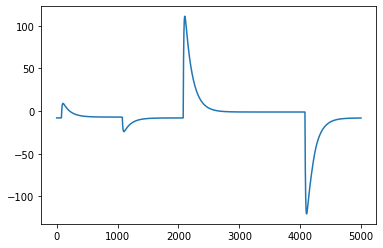

In [7]:
#         C_p     C     a0_m  b0_m  delta_m  s_m   a0_h  b0_h   delta_h  s_h      R    R_p   g_max  g_leak
x_true = [6e-15, 12e-12, 5e2,  80,     0.85,   6,     2,   4e4,    0.5,     6,    5e8,   5e7,   5e1,   1e-1]
x_true_log = np.log(x_true)

t = np.load('../data/time.npy')

v_list = v_all#np.array([-80, -80, -70, -80, -10, -80])
k_list = k_all#np.array([77, 1077, 2077, 4077]) 
dt = t[1] - t[0]

kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = False)#,
              #sample_weights = sample_weight)

data = calculate_I_out(x_true_log, kwargs) 

plt.figure()
plt.plot(data)

In [8]:
if False:
    #         C_f     C     a0_m  b0_m  delta_m  s_m   a0_h  b0_h   delta_h  s_h      R    R_f   g_max  g_leak
    x_true = [6e-15, 12e-12, 5e2,  80,     0.85,   6,     2,   4e4,    0.5,     6,    5e8,   5e7,   5e1,   1e-1]

    x_true_log = np.log(x_true)

    t = np.load('../data/time.npy')
    t = np.concatenate([t for k in range(20)])

    v_list = v_all#np.array([-80, -80, -70, -80, -10, -80])
    k_list = k_all#np.array([77, 1077, 2077, 4077]) 
    dt = t[1] - t[0]

    kwargs = dict(v_list = v_list,
                  k_list = k_list,
                  t = t,
                  log_scale = True)

    data = calculate_I_out(x_true_log, kwargs) # np.load('../data/simulated_func.npy')
    #plt.xlim(0,5e3)
    #plt.xlim(5e3,10e3)
    plt.figure()
    plt.plot(data)

In [9]:
def loss(x, *args):
    kwargs = args[-1]
    data = args[0]
    sample_weight = kwargs.get('sample_weight', None)
    I_out = calculate_I_out(x, *args)
    
    if np.any(np.isnan(I_out)):
        return np.inf
        
    return MSE(data, I_out, sample_weight=sample_weight)

In [10]:
%%timeit

kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = False)
loss(x_true_log, data, kwargs)

2.81 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
names =  ["C_f","C","a0_m","b0_m","delta_m","s_m","a0_h","b0_h" ,"delta_h","s_h","R"   , "R_f"  , "g_max"  ,"g_leak"]

x0 = x_true_log - 1
bounds = np.vstack([x_true_log  - 3, x_true_log + 3]).T
loss(x_true_log, data, kwargs)

0.0

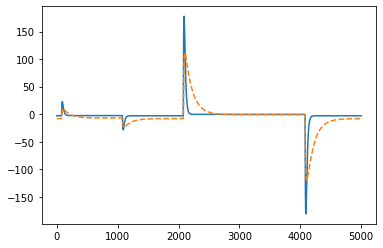

In [12]:
plt.plot(calculate_I_out(x0, kwargs))
plt.plot(data, '--')

### minimize

In [13]:
%%time
res = scop.minimize(loss, x0, bounds=bounds, args=(data, kwargs))

CPU times: user 654 ms, sys: 3.04 ms, total: 657 ms
Wall time: 740 ms


In [14]:
loss(res.x, data, kwargs)

0.11750178097882667

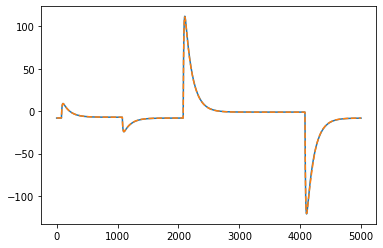

In [15]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(data, '--')

 ### real_data_minimize


In [34]:
real_data = pd.read_csv('../data/training/2020_12_19_0035 I-V INa 11,65 pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
real_data_small = real_data[14]
#real_data = np.concatenate([real_data[k] for k in range(1,21)])

#sample_weights = np.zeros(5000)
#sample_weights[2210:4000] += 1


#           C_f     C    a0_m   b0_m    delta_m   s_m    a0_h   b0_h   delta_h  s_h      R    R_f   g_max g_leak
bounds = ([1e-20, 1e-13, 1e-10, 1e-10,  1e-10,   1e-10,  1e-10, 1e-10, 1e-10,   1e-10,  1e5,  1e3,  1e-5, 1e-5],
          [1e-9,  1e-10, 1e8,   1e6,    1,       1e4,    1e8,   1e8,   1,       1e8,    1e15, 1e15, 1e5,  1e5])
log_bounds = np.vstack([np.log(bounds[0]),np.log(bounds[1])]).T
kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = False)#,
              #sample_weight = sample_weights)


In [35]:
%%time
res = scop.minimize(loss, x_true_log, bounds=log_bounds, args=(real_data_small, kwargs))#, tol = 1e-6)#,method = 'Nelder-Mead',
               #options={'maxfev':5e10, 'adaptive':True})

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by ze

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by ze

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by ze

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by ze

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by ze

<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWar

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by ze

<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWar

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by ze

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by ze

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by ze

<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWar

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by ze

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by ze

<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWar

<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWar

<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWar

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by ze

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by ze

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by ze

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by ze

<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWar

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by ze

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by ze

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by ze

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by ze

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by ze

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by ze

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by ze

<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWar

<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWar

CPU times: user 15.5 s, sys: 287 ms, total: 15.8 s
Wall time: 15.7 s


<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by ze

In [36]:
loss(res.x, real_data_small, kwargs)

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)


876.2645309585448

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)


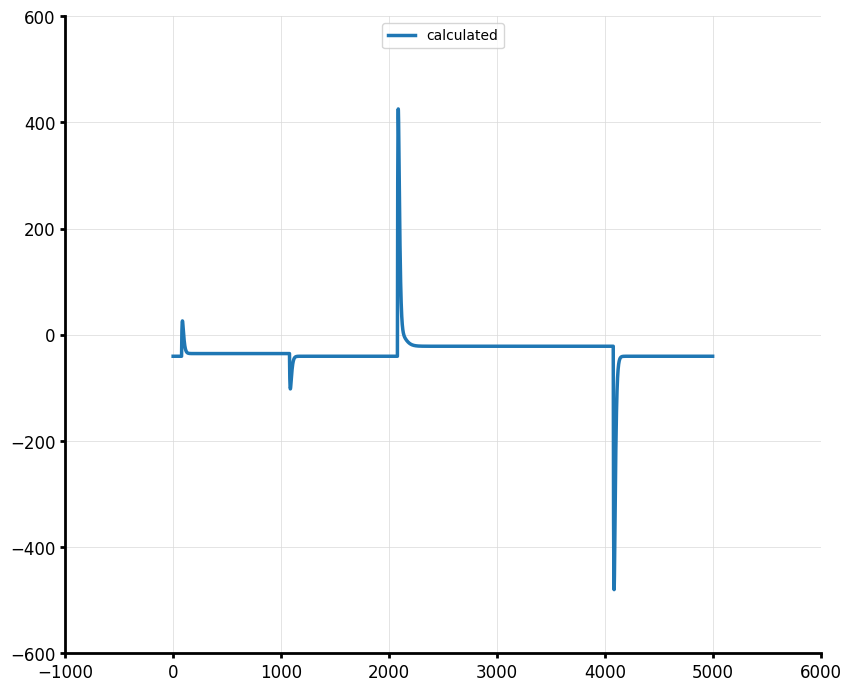

In [37]:
plt.plot(calculate_I_out(res.x, kwargs), label = 'calculated')

plt.legend()
#plt.axvline(2210)
#plt.plot(real_data_small, '--', label = 'real data')

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)


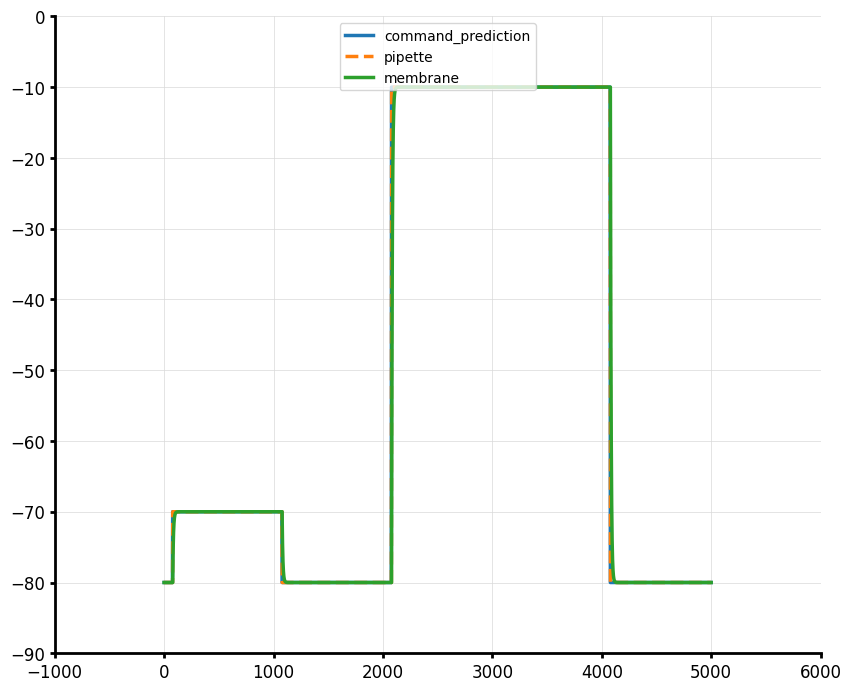

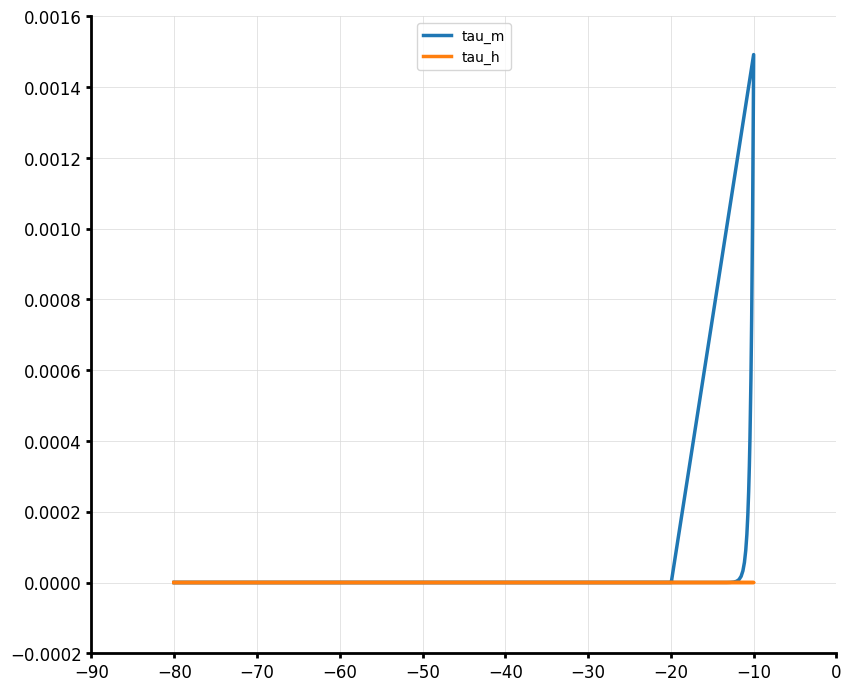

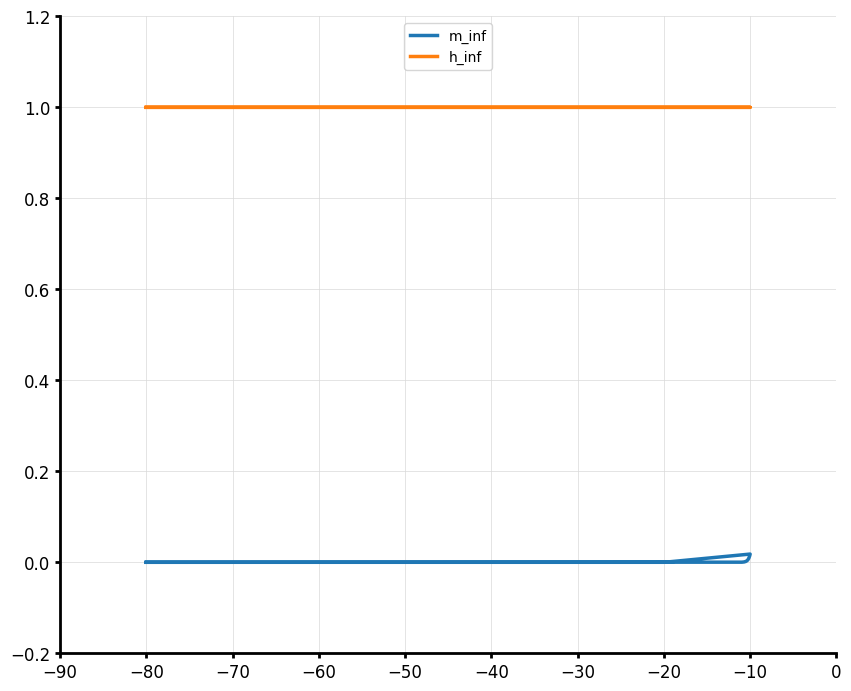

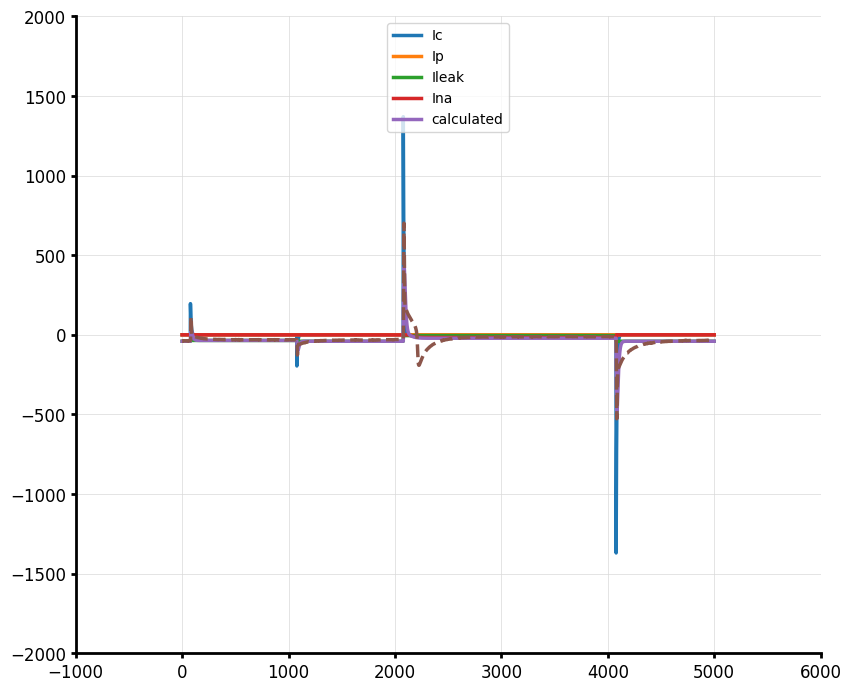

In [38]:
kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = True)#,
              #sample_weight = sample_weights)
plt.plot(calculate_I_out(res.x, kwargs), label = 'calculated')

plt.legend()
#plt.axvline(2210)
plt.plot(real_data_small, '--', label = 'real data')

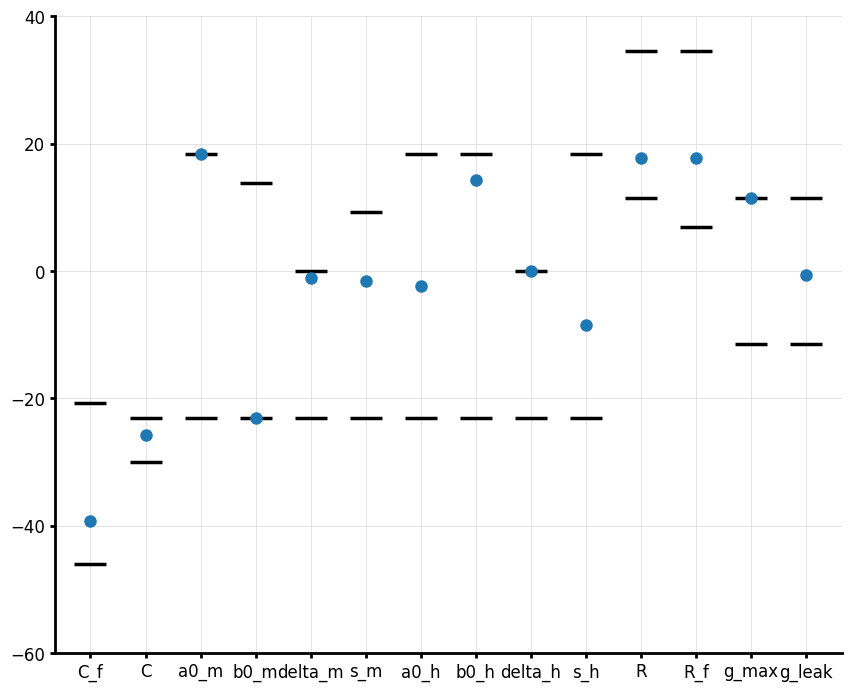

In [39]:
plt.scatter(names,log_bounds.T[0], marker = '_', s = 500, c = 'k')
plt.scatter(names,log_bounds.T[1], marker = '_', s = 500, c = 'k')
plt.scatter(names, res.x)

In [40]:
for k in range(len(res.x)):
    print(names[k], ' = ',np.exp(res.x)[k])

C_f  =  9.132135433885798e-18
C  =  6.88122646862845e-12
a0_m  =  100000000.00000018
b0_m  =  9.999999999999996e-11
delta_m  =  0.3504854418554936
s_m  =  0.22006011936670652
a0_h  =  0.09515465936710645
b0_h  =  1502576.1560263783
delta_h  =  1.0
s_h  =  0.00020453883287646193
R  =  47372268.95784737
R_f  =  49999999.99999999
g_max  =  100000.00000000001
g_leak  =  0.5050545260002244


### differential_evolution

In [ ]:
%%time
res = scop.differential_evolution(loss,
                                  bounds=log_bounds,
                                  args=(real_data_small, kwargs),
                                  maxiter=10, # I don't want to wait too long
                                  #disp=True,
                                  workers=-1,
                                  seed=42,
                                  )

/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_differentialevolution.py:495: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  warnings.warn("differential_evolution: the 'workers' keyword has"
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWa

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in multiply
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWar

<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d848

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:72: RuntimeWar

<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d848

<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:88: RuntimeWar

<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72

<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: 

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: 

<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in multiply
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:72: RuntimeWarn

<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d848

<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWar

<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: Runt

<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d848

<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: 

<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d848

<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:89: RuntimeWar

<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-33-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-33-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-33-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-33-14d5f6d84868>:88: RuntimeWar

In [ ]:
res

In [ ]:
loss(res.x, real_data_small, kwargs)

In [ ]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(real_data_small, '--')

### dual_annealing

In [ ]:
%%time
res = scop.dual_annealing(loss, bounds=log_bounds, x0 = x_true_log, args=(real_data_small, kwargs), seed=42)

In [ ]:
res

In [ ]:
loss(res.x, real_data_small, kwargs)

In [ ]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(real_data_small, '--')